In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# %load_ext autotime
import geopy
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px

In [42]:
def locate_neighborhood(coordinates: str) -> str:
    locator = Nominatim(user_agent='myGeocoder', timeout=10)
    rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)
    location = locator.reverse(coordinates)
    
    split_address = location.address.split(',')
    
    if len(split_address) == 11:
        return split_address[2][1:]
    
    return split_address[3][1:]

In [25]:
simulated = pd.read_csv('simulated_listings.csv')

simulated.rename(inplace=True, columns={
    'Unnamed: 0':'Apartment_ID',
    'rooms':'Rooms',
    'garages':'Garage',
    'useful_area':'Useful_Area',
    'latitude':'Latitude',
    'longitude':'Longitude', 
    'value':'Market_Value',
    'interior_quality':'Condition',
    'time_on_market':'Time_on_Market',
    'sold': 'Sold'
})
simulated['Latitude'] = simulated['Latitude'].astype(str)
simulated['Longitude'] = simulated['Longitude'].astype(str)
simulated['Condition'] = simulated['Condition'].astype(str)
simulated['Coordinates'] = simulated['Latitude'] + ', ' + simulated['Longitude']

In [24]:
target = pd.read_csv('target_apartments.csv')

target.rename(inplace=True, columns={
    'Unnamed: 0':'Apartment_ID',
    'rooms':'Rooms',
    'garages':'Garage',
    'useful_area':'Useful_Area',
    'latitude':'Latitude',
    'longitude':'Longitude', 
    'value':'Seller_Value',
    'interior_quality':'Condition'})
target['Latitude'] = target['Latitude'].astype(str)
target['Longitude'] = target['Longitude'].astype(str)
target['Coordinates'] = target['Latitude'] + ', ' + target['Longitude']

In [31]:
simulated.sort_values(['Time_on_Market','Sold'], axis = 0, ascending=True, inplace=True)

In [35]:
sold = simulated.copy()[simulated['Sold'] == 1]
selling = simulated.copy()[simulated['Sold'] == 0]

In [56]:
top10_liquidity = sold.head(10)
top10_liquidity['Neighborhood'] = top10_liquidity.apply(lambda row: locate_neighborhood(row['Coordinates']), axis = 1);

tail10_liquidity = sold.tail(10)
tail10_liquidity['Neighborhood'] = tail10_liquidity.apply(lambda row: locate_neighborhood(row['Coordinates']), axis = 1);

/nix/store/p88yyfxyx0w1w888cws5sl1nq6x5qig5-python3-3.7.6-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
neighborhoods = top10_liquidity['Neighborhood'].drop_duplicates().tolist()
neighborhoods_count = top10_liquidity['Neighborhood'].value_counts().tolist()

conditions = sold['Condition'].drop_duplicates().tolist()
conditions_count = sold['Condition'].value_counts().tolist()

Contexto

O mercado imobiliário sempre foi bastante burocrático e temido por grande parte da população que busca adquirir seu imóvel, seja ele o primeiro ou não.
Dessa forma, a tecnologia deve ser a nossa maior aliada no combate da burocracia e entrega de um produto com valor agregado e maior assertividade ao nosso cliente. O objetivo desse estudo é entender o comportamento de vendas de apartamentos pela cidade de São Paulo, as preferencias e características mais procuradas pelos compradores para compormos uma carteira com apartamentos diversos, mas que sejam líquidos e tragam retorno, gerando assim um ambiente saudável de desenvolvimento da empresa.
Hipóteses 
Dado o momento atual, encontramos as seguintes questões e suas respectivas hipóteses e variáveis presentes na compra de um imóvel:
A Loft deveria comprar o apartamento e transacionar através do IBuyer, ou apenas anunciá-lo no marketplace?
•	Os compradores estudam as condições do imóvel antes de adquiri-lo? Se sim, é importante estudar qual a preferência deles em relação ao estado de conservação;
•	Quais são os bairros mais líquidos, e dentre eles, qual estrutura de apartamento é a mais buscada e comprada.
Qual o preço justo de anúncio dos apartamentos, tanto para o comprador quanto para a estratégia de desenvolvimento da Loft?
•	Caso o apartamento esteja em um bairro líquido, e esteja em uma condição não totalmente reformado, qual a margem de ganhos que a Loft prevê sobre esse imóvel.
•	Se os apartamentos já se encontram em estado 3 de conservação e são menos líquidos, de qual forma podemos anuncia-los de maneira mais assertiva em nossa plataforma. 

Objetivos

Nosso principal objetivo através desse estudo é encontrar uma forma de preencher mais nossa carteira de imóveis e forma mais coerente com nossos planos e mais assertiva com os compradores que entram em nossa plataforma em busca de seu imóvel. 

Métricas
Uma estratégia de portfolio tem como objetivo ter os melhores produtos e oferece-los da melhor forma aos nossos consumidores. Dessa forma, nosso maior indicador de sucesso é o numero de apartamentos vendidos, e a quantidade de tempo que eles permanecem na nossa plataforma até a sua venda. Isso pode ser considerada uma das facetas na classificação de um ativo liquido em relação ao outro.

Decisões para serem tomadas baseadas nos resultados
Como dito anteriormente, nosso objetivo é ampliar o número de apartamentos disponíveis na nossa plataforma. Dessa forma, vamos estudar nichos específicos de informação, buscando padrões entre elas a fim de estabelecer determinado comportamento. 

Testes e Grupos de Informações
Os dados escolhidos forma os seguintes: Número de dias disponível na plataforma, bairro, condições e tamanho.

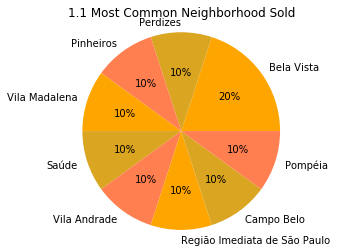

Rooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,Total,% Apartment
Condition,,,,,,,,,,
1,45,130,233,134,9,1,0,0,552,11.1%
2,108,354,576,390,9,0,1,1,1439,29.1%
3,214,696,1208,816,26,2,0,0,2962,59.8%


In [68]:
fig1, ax1 = plt.subplots()

ax1.pie(neighborhoods_count, 
        labels=neighborhoods, 
        autopct='%1.0f%%', 
        shadow=False, 
        startangle=360, 
        colors=['orange', 'goldenrod', 'coral']
)
ax1.axis('equal') 
plt.title('1.1 Most Common Neighborhood Sold')
plt.show()

sold_cross = pd.crosstab(sold['Condition'], sold['Rooms'])
sold_cross['Total'] = sold_cross.sum(axis=1)
sold_cross['% Apartment'] = sold['Condition'] \
    .value_counts(normalize=True) \
    .mul(100) \
    .round(1) \
    .astype(str) + '%'
    
sold_cross


Através dos nossos dados, expostos acima no gráfico 1.1 e tabela, conseguimos estabelecer alguns padrões para o consumo de imóveis através da nossa plataforma.
A maioria dos apartamentos vendidos encontram-se na zona oeste da cidade de São Paulo, e sua condição mais comum é a 3, que é o modelo de reforma da Loft através do IBuyer, seguidos da condição 2.

Ainda analisando a tabela acima, podemos notar que os apartamentos com um número médio de 3 dormitórios são os favorito entre os nossos clientes, e podemos concluir que são apartamentos mais  “apostáveis” para incluir em nosso portfólio.


In [74]:
def calculate_y_for_rooms(rooms_count):
    return sold.loc[sold['Rooms'] == rooms_count, 'Market_Value']

trace1 = go.Box(y=calculate_y_for_rooms(1),
                name='1 Room',
                marker={'color': '#f39c12'})
trace2 = go.Box(y=calculate_y_for_rooms(2),
                name='2 Rooms',
                marker={'color': '#e67e22'})
trace3 = go.Box(y=calculate_y_for_rooms(3),
                name='3 Rooms',
                marker={'color': '#d35400'})
trace4 = go.Box(y=calculate_y_for_rooms(4),
                name='4 Rooms',
                marker={'color': '#ea8685'})
trace5 = go.Box(y=calculate_y_for_rooms(5),
                name='5 Rooms',
                marker={'color': '#f19066'})
trace8 = go.Box(y=calculate_y_for_rooms(8),
                name='8 Rooms',
                marker={'color': '#f3a683'})

data = [trace1, trace2, trace3, trace4, trace5, trace8]
layout = go.Layout(title='Price dispersion for apartments with different rooms',
                   titlefont={'family': 'Arial',
                              'size': 22,
                              'color': '#7f7f7f'},
                   xaxis={'title': 'Rooms'},
                   yaxis={'title': 'Price'},
                   paper_bgcolor='rgb(243, 243, 243)',
                   plot_bgcolor='rgb(243, 243, 243)')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Os preços de cada um dos apartamentos também é uma das características fundamentais para o comprador fechar o negócio, por isso, mapeamos abaixo a faixa de preços atingidas por diferentes tipos de aparamento, baseado no numero de quartos, e consequentemente no tamanho dos apartamentos que foram vendidos através da nossa plataforma.

In [78]:
condition_selling_count = selling['Condition'].value_counts().tolist()

conditions_selling_name = selling['Condition'].drop_duplicates().tolist()

trace1 = go.Bar(x=conditions,
                y=conditions_count,
                name='Apartment sold',
                marker={'color': '#F06023'})

trace2 = go.Bar(x=conditions_selling_name,
                y=condition_selling_count,
                name='Apartment selling',
                marker={'color': '#EB8D1A'})

data = [trace1, trace2]
layout = go.Layout(title = 'Relationship between sold and selling based on condition',
                   xaxis = {'title': 'Condition'},
                   yaxis = {'title': '# of Apartments'},
                   barmode = 'stack')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Levando em consideração todas essas variáveis, dividimos a nossa base de apartamentos entre ‘Vendidos’ e ‘Vendendo’, para ter uma maior visualização da relação entre eles e as condições oferecidas na plataforma. Dessa maneira, podemos dizer com mais precisão qual condição de apartamento devemos ter em maior quantidade em nossa plataforma. E qual tipo de condição podemos apenas negociar através do marketplace, tornando nosso sistema mais sustentável e rentável.

Considerando todos os dados já apresentamos, avaliaremos apartamentos que poderão ou não fazer parte do portfólio da Loft seguindo as mesma lógica para selecionarmos ou não um imóvel.


Desafio e roteiro
Seu desafio é criar, dada a sua interpretação do momento atual do negócio da Loft, uma política
de alocação de portfólio para decidir, entre os apartamentos disponíveis na
target_apartments.csv, quais a Loft deve transacionar via iBuyer (comprar, reformar e vender),
quais deveríamos transacionar via marketplace (listar na plataforma, sem adquirir o
apartamento), e por qual preço a Loft deve listar na sua plataforma, no seguinte cenário:
● Pagamos exatamente o valor pedido pelo proprietário (coluna value na base
target_apartments.csv).
● A reforma traz o apartamento para o melhor estado de conservação possível
(interior_quality=3).
● O capital disponível para compra dos apartamentos é de R$ 150 milhões.

In [84]:
def build_action(row):
    if row['Rooms'] <= 3 and row['Condition'] == 1:
        return 'Buy'
    
    return 'Not Yet'

target['Action'] = target.apply(build_action, axis=1)

In [87]:
target_buy = target.query('Rooms != 1 & Action == "Buy" & Useful_Area > 65 & Useful_Area < 180')

try:
    target_buy['Neighborhood'] = target_buy.apply(lambda row: locate_neighborhood(row['Coordinates']), axis=1)
except:
    target_buy = pd.read_csv('target_buy_fallback.csv')

/nix/store/p88yyfxyx0w1w888cws5sl1nq6x5qig5-python3-3.7.6-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
# df = target_buy.groupby('Neighborhood')
# df.head(50)
neighborhoods.remove('Região Imediata de São Paulo')
final_buy = target_buy[target_buy['Neighborhood'].isin(neighborhoods)]

ValueError: list.remove(x): x not in list

In [92]:
neighborhood_buys = final_buy['Neighborhood'].drop_duplicates().tolist()
neighborhood_buy_count = final_buy['Neighborhood'].value_counts().tolist()

trace1 = go.Scatter(x=neighborhood_buys,
                    y=neighborhood_buy_count,
                    mode='lines+markers+text',
                    name='Apartments by neighborhood',
                    line={'color': '#F06023',
                          'dash': 'dash'})

data = [trace1]
py.iplot(data)

In [97]:
mean_price_to_buy = final_buy.mean()['Seller_Value']
total_price_to_buy = final_buy.sum()['Seller_Value']
sold_condition_3 = sold.filter(like='3', axis=0)
mean_price_sold = sold_condition_3.mean()['Market_Value']

median_price_to_buy = final_buy.median()['Seller_Value']
median_price_sold = sold_condition_3.median()['Market_Value']

85232374

In [98]:
diff_price =  mean_price_sold - mean_price_to_buy
diff_median = median_price_sold - median_price_to_buy
financial_data = pd.DataFrame([(diff_median, diff_price)], columns = ['diff_median', 'diff_price'])
financial_data

,diff_median,diff_price
0,377105.0,860370.168609
